# Detección de Anomalías Transaccionales en Parqueo (Hipótesis 1)

## Objetivo
Desarrollar un modelo de IA no supervisado que detecte automáticamente anomalías en el comportamiento transaccional (volumen de sesiones y ingresos) de los lotes de parqueo, basándose en patrones diarios, semanales y estacionales predecibles.

### Hipótesis
El comportamiento transaccional de un lote de parqueo sigue patrones diarios, semanales y estacionales predecibles. Las desviaciones significativas del comportamiento 'normal' indican problemas operativos (ej. evasión de pago) o eventos atípicos.

---

## 0. Configuración del Entorno

In [13]:
# Importar librerías esenciales
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías de Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Librerías para series de tiempo
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

# Librerías para Deep Learning (Autoencoder)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.optimizers import Adam
    HAS_TENSORFLOW = True
except ImportError:
    print("TensorFlow no está disponible. Se omitirán los modelos de Autoencoder.")
    HAS_TENSORFLOW = False

# Configuración general
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Constantes
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if HAS_TENSORFLOW:
    tf.random.set_seed(RANDOM_SEED)

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("✅ Configuración del entorno completada")
print(f"📊 Pandas: {pd.__version__}")
print(f"🔢 NumPy: {np.__version__}")
print(f"🤖 TensorFlow disponible: {HAS_TENSORFLOW}")
if HAS_TENSORFLOW:
    print(f"🧠 TensorFlow: {tf.__version__}")

TensorFlow no está disponible. Se omitirán los modelos de Autoencoder.
✅ Configuración del entorno completada
📊 Pandas: 2.2.3
🔢 NumPy: 2.1.3
🤖 TensorFlow disponible: False


## 1. Carga y Limpieza de Datos (Extract & Transform)

In [14]:
# Cargar el dataset
print("📂 Cargando datos...")
try:
    df_raw = pd.read_excel('data.xlsx')
    print(f"✅ Dataset cargado exitosamente: {df_raw.shape}")
    print(f"📊 Columnas: {list(df_raw.columns)}")
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")
    raise

# Mostrar información básica del dataset
print("\n📋 Información del dataset:")
print(df_raw.info())
print("\n📊 Primeras 5 filas:")
df_raw.head()

📂 Cargando datos...
✅ Dataset cargado exitosamente: (9335, 12)
📊 Columnas: ['session_id', 'start_time', 'end_time', 'zone number', 'parking_fee', 'convenience_fee', 'transaction_fee', 'net_revenue', 'car id', 'vehicle_state', 'transaction_method', 'payment_type']

📋 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335 entries, 0 to 9334
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   session_id          9335 non-null   int64  
 1   start_time          9335 non-null   object 
 2   end_time            9335 non-null   object 
 3   zone number         9335 non-null   int64  
 4   parking_fee         9335 non-null   float64
 5   convenience_fee     9335 non-null   float64
 6   transaction_fee     9335 non-null   float64
 7   net_revenue         9335 non-null   float64
 8   car id              9335 non-null   int64  
 9   vehicle_state       9335 non-null   object 
 10  transact

,session_id,start_time,end_time,zone number,parking_fee,convenience_fee,transaction_fee,net_revenue,car id,vehicle_state,transaction_method,payment_type
0,676035745,2025-06-08 19:17:00+00,2025-06-08 21:17:00+00,1,3.0,0.35,0.12,3.23,904,FL,app,Credit/Debit Card
1,673764355,2025-06-01 17:26:00+00,2025-06-01 19:26:00+00,2,0.0,0.00,0.12,-0.12,2377,FL,app,Free
2,677832093,2025-06-13 23:57:00+00,2025-06-14 02:57:00+00,2,2.0,0.35,0.12,2.23,2010,FL,app,Credit/Debit Card
3,673799618,2025-06-01 20:04:00+00,2025-06-01 23:04:00+00,1,5.0,0.35,0.12,5.23,509,FL,app,Credit/Debit Card
4,673731483,2025-06-01 14:27:00+00,2025-06-01 16:27:00+00,3,0.0,0.00,0.12,-0.12,4204,NJ,app,Free


### 1.1 Validación de Datos según Diccionario

In [15]:
# Crear una copia para la limpieza
df = df_raw.copy()

# Estandarizar nombres de columnas según el diccionario
column_mapping = {
    'zone number': 'zone_number',
    'car id': 'car_id'
}
df = df.rename(columns=column_mapping)

print("🔍 VALIDACIÓN DE DATOS según diccionario de datos")
print("=" * 60)

# 1. Verificar session_id como PK (chequear duplicados)
print("1️⃣ Verificando session_id como clave primaria...")
duplicated_sessions = df['session_id'].duplicated().sum()
total_sessions = len(df)
unique_sessions = df['session_id'].nunique()

print(f"   📊 Total de registros: {total_sessions:,}")
print(f"   🔑 Session IDs únicos: {unique_sessions:,}")
print(f"   🚨 Session IDs duplicados: {duplicated_sessions}")

if duplicated_sessions > 0:
    print("   ⚠️  PROBLEMA: Se encontraron session_ids duplicados")
    duplicate_ids = df[df['session_id'].duplicated(keep=False)]['session_id'].unique()
    print(f"   🔍 IDs duplicados: {duplicate_ids}")
else:
    print("   ✅ session_id es efectivamente una clave primaria")

print("\n" + "="*60)

🔍 VALIDACIÓN DE DATOS según diccionario de datos
1️⃣ Verificando session_id como clave primaria...
   📊 Total de registros: 9,335
   🔑 Session IDs únicos: 9,335
   🚨 Session IDs duplicados: 0
   ✅ session_id es efectivamente una clave primaria



In [16]:
# 2. Convertir start_time y end_time a datetime
print("2️⃣ Convirtiendo campos de tiempo a datetime...")

# Verificar el tipo actual
print(f"   📅 Tipo actual de start_time: {df['start_time'].dtype}")
print(f"   📅 Tipo actual de end_time: {df['end_time'].dtype}")

# Mostrar algunos valores de ejemplo
print(f"   🔍 Muestra start_time: {df['start_time'].head(3).tolist()}")
print(f"   🔍 Muestra end_time: {df['end_time'].head(3).tolist()}")

# Convertir a datetime
try:
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    print("   ✅ Conversión a datetime exitosa")
except Exception as e:
    print(f"   ❌ Error en conversión: {e}")

print(f"   📅 Nuevo tipo start_time: {df['start_time'].dtype}")
print(f"   📅 Nuevo tipo end_time: {df['end_time'].dtype}")

print("\n" + "="*60)

2️⃣ Convirtiendo campos de tiempo a datetime...
   📅 Tipo actual de start_time: object
   📅 Tipo actual de end_time: object
   🔍 Muestra start_time: ['2025-06-08 19:17:00+00', '2025-06-01 17:26:00+00', '2025-06-13 23:57:00+00']
   🔍 Muestra end_time: ['2025-06-08 21:17:00+00', '2025-06-01 19:26:00+00', '2025-06-14 02:57:00+00']
   ✅ Conversión a datetime exitosa
   📅 Nuevo tipo start_time: datetime64[ns, UTC]
   📅 Nuevo tipo end_time: datetime64[ns, UTC]



In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335 entries, 0 to 9334
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   session_id          9335 non-null   int64              
 1   start_time          9335 non-null   datetime64[ns, UTC]
 2   end_time            9335 non-null   datetime64[ns, UTC]
 3   zone_number         9335 non-null   int64              
 4   parking_fee         9335 non-null   float64            
 5   convenience_fee     9335 non-null   float64            
 6   transaction_fee     9335 non-null   float64            
 7   net_revenue         9335 non-null   float64            
 8   car_id              9335 non-null   int64              
 9   vehicle_state       9335 non-null   object             
 10  transaction_method  9335 non-null   object             
 11  payment_type        9335 non-null   object             
dtypes: datetime64[ns, UTC](2), float64

In [18]:
# 3. Limpieza Numérica CRÍTICA: Convertir campos financieros
print("3️⃣ Limpieza de campos financieros (reemplazar comas por puntos)...")

numeric_fields = ['convenience_fee', 'transaction_fee', 'net_revenue']
for field in numeric_fields:
    if field in df.columns:
        print(f"   💰 Procesando {field}...")
        
        # Verificar tipo actual
        print(f"      📊 Tipo actual: {df[field].dtype}")
        
        # Mostrar algunos valores de ejemplo antes de la limpieza
        sample_values = df[field].dropna().head(5).tolist()
        print(f"      🔍 Valores ejemplo (antes): {sample_values}")
        
        # Si es string, reemplazar comas por puntos
        if df[field].dtype == 'object':
            df[field] = df[field].astype(str).str.replace(',', '.', regex=False)
            print(f"      🔧 Comas reemplazadas por puntos")
        
        # Convertir a numérico
        try:
            df[field] = pd.to_numeric(df[field], errors='coerce')
            print(f"      ✅ Conversión a numérico exitosa")
            
            # Mostrar estadísticas básicas
            print(f"      📈 Min: {df[field].min():.2f}, Max: {df[field].max():.2f}")
            print(f"      📊 Valores nulos: {df[field].isnull().sum()}")
            
        except Exception as e:
            print(f"      ❌ Error en conversión: {e}")
    else:
        print(f"   ⚠️  Campo {field} no encontrado en el dataset")

print("\n" + "="*60)

3️⃣ Limpieza de campos financieros (reemplazar comas por puntos)...
   💰 Procesando convenience_fee...
      📊 Tipo actual: float64
      🔍 Valores ejemplo (antes): [0.35, 0.0, 0.35, 0.35, 0.0]
      ✅ Conversión a numérico exitosa
      📈 Min: 0.00, Max: 1.40
      📊 Valores nulos: 0
   💰 Procesando transaction_fee...
      📊 Tipo actual: float64
      🔍 Valores ejemplo (antes): [0.12, 0.12, 0.12, 0.12, 0.12]
      ✅ Conversión a numérico exitosa
      📈 Min: 0.12, Max: 0.48
      📊 Valores nulos: 0
   💰 Procesando net_revenue...
      📊 Tipo actual: float64
      🔍 Valores ejemplo (antes): [3.23, -0.12, 2.23, 5.23, -0.12]
      ✅ Conversión a numérico exitosa
      📈 Min: -0.12, Max: 42.23
      📊 Valores nulos: 0



In [19]:
# 4. Verificar consistencia: end_time >= start_time
print("4️⃣ Verificando consistencia temporal (end_time >= start_time)...")

# Calcular duración
df['duration_minutes'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60

# Verificar consistencia
inconsistent_records = (df['duration_minutes'] < 0).sum()
zero_duration = (df['duration_minutes'] == 0).sum()
total_records = len(df)

print(f"   📊 Total de registros: {total_records:,}")
print(f"   ❌ Registros inconsistentes (duración negativa): {inconsistent_records}")
print(f"   ⚪ Registros con duración cero: {zero_duration}")
print(f"   ✅ Registros válidos: {total_records - inconsistent_records:,}")

if inconsistent_records > 0:
    print("   🔍 Analizando registros inconsistentes...")
    inconsistent_df = df[df['duration_minutes'] < 0]
    print(inconsistent_df[['session_id', 'start_time', 'end_time', 'duration_minutes']].head())
    
    # Opción: eliminar registros inconsistentes
    print(f"   🚨 Eliminando {inconsistent_records} registros inconsistentes...")
    df = df[df['duration_minutes'] >= 0].copy()
    print(f"   📊 Dataset después de limpieza: {len(df):,} registros")

# Estadísticas de duración
print(f"\n   📈 Estadísticas de duración (minutos):")
print(f"      Min: {df['duration_minutes'].min():.1f}")
print(f"      Max: {df['duration_minutes'].max():.1f}. Tiempo en horas: {df['duration_minutes'].max()/60:.1f}h")
print(f"      Media: {df['duration_minutes'].mean():.1f}, Tiempo en horas: {df['duration_minutes'].mean()/60:.1f}h")
print(f"      Mediana: {df['duration_minutes'].median():.1f}, Tiempo en horas: {df['duration_minutes'].median()/60:.1f}h")

print("\n" + "="*60)

4️⃣ Verificando consistencia temporal (end_time >= start_time)...
   📊 Total de registros: 9,335
   ❌ Registros inconsistentes (duración negativa): 0
   ⚪ Registros con duración cero: 0
   ✅ Registros válidos: 9,335

   📈 Estadísticas de duración (minutos):
      Min: 6.0
      Max: 1440.0. Tiempo en horas: 24.0h
      Media: 157.8, Tiempo en horas: 2.6h
      Mediana: 120.0, Tiempo en horas: 2.0h



5️⃣ Graficando distribución de duraciones agrupadas por horas...


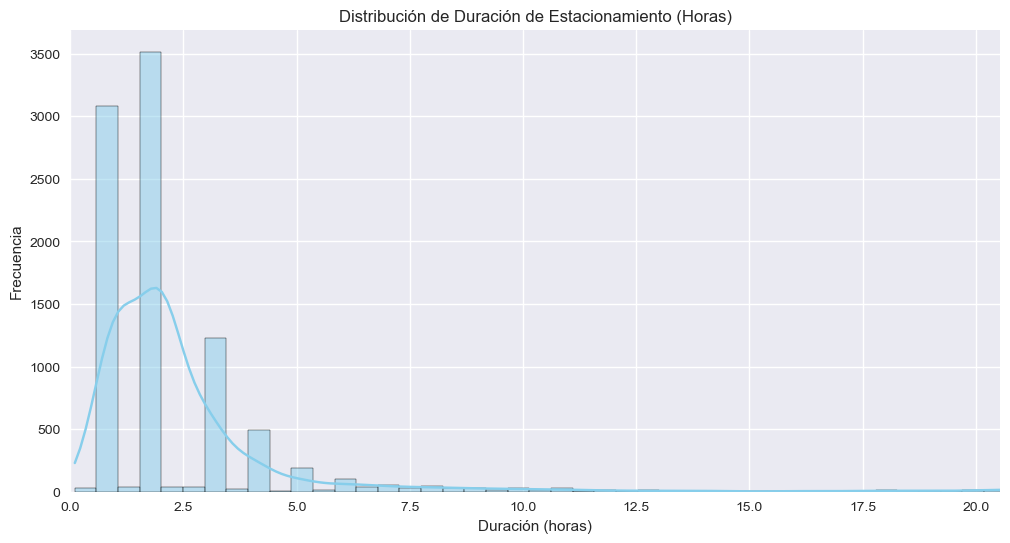

6️⃣ Graficando duración por zonas...


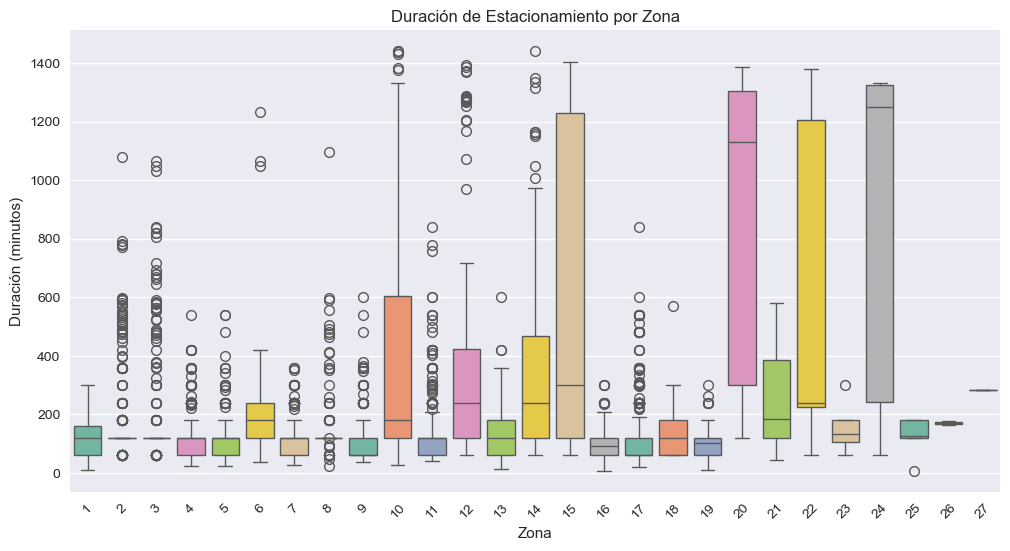

In [20]:
# Graficar distribución de duraciones por horas
print("5️⃣ Graficando distribución de duraciones agrupadas por horas...")
plt.figure(figsize=(12,6))
df['duration_hours'] = df['duration_minutes'] / 60
sns.histplot(df['duration_hours'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de Duración de Estacionamiento (Horas)')
plt.xlabel('Duración (horas)')
plt.ylabel('Frecuencia')
plt.xlim(0, df['duration_hours'].quantile(0.99))  # Limitar eje x al percentil 99 para mejor visualización
plt.show()

# graficar en cajas la duración por zonas
print("6️⃣ Graficando duración por zonas...")
plt.figure(figsize=(12,6))
sns.boxplot(x='zone_number', y='duration_minutes', data=df, palette='Set2')
plt.title('Duración de Estacionamiento por Zona')
plt.xlabel('Zona')
plt.ylabel('Duración (minutos)')
plt.xticks(rotation=45)
plt.show()

In [21]:
# 5. Resumen final de la limpieza
print("5️⃣ RESUMEN FINAL DE LIMPIEZA")
print("=" * 60)

print("📊 Información final del dataset:")
print(df.info())

print(f"\n📈 Estadísticas descriptivas de campos numéricos:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(df[numeric_cols].describe())

print(f"\n📅 Rango temporal de los datos:")
print(f"   🕐 Inicio más temprano: {df['start_time'].min()}")
print(f"   🕕 Inicio más tardío: {df['start_time'].max()}")
print(f"   📆 Período total: {(df['start_time'].max() - df['start_time'].min()).days} días")

print(f"\n🏢 Información de zonas:")
print(f"   🅿️ Zonas únicas: {df['zone_number'].nunique()}")
print(f"   📊 Zonas disponibles: {sorted(df['zone_number'].unique())}")

# Checkpoint: Guardar dataset limpio
print(f"\n💾 Guardando dataset limpio como checkpoint...")
df.to_pickle('data_cleaned.pkl')
print(f"✅ Dataset limpio guardado: {len(df):,} registros")

print("\n🎉 LIMPIEZA COMPLETADA EXITOSAMENTE")

5️⃣ RESUMEN FINAL DE LIMPIEZA
📊 Información final del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335 entries, 0 to 9334
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   session_id          9335 non-null   int64              
 1   start_time          9335 non-null   datetime64[ns, UTC]
 2   end_time            9335 non-null   datetime64[ns, UTC]
 3   zone_number         9335 non-null   int64              
 4   parking_fee         9335 non-null   float64            
 5   convenience_fee     9335 non-null   float64            
 6   transaction_fee     9335 non-null   float64            
 7   net_revenue         9335 non-null   float64            
 8   car_id              9335 non-null   int64              
 9   vehicle_state       9335 non-null   object             
 10  transaction_method  9335 non-null   object             
 11  payment_type        9335 non-nul

## 2. Ingeniería de Features y Agregación

In [22]:
# OBJETIVO: Transformar datos transaccionales (nivel session_id) 
# en series de tiempo (nivel zone_number + start_hour)

print("🔄 INGENIERÍA DE FEATURES Y AGREGACIÓN")
print("=" * 60)

# Paso 2.1: Crear start_hour para agregación temporal
print("2.1️⃣ Creando timestamp de agregación horaria...")

df['start_hour'] = df['start_time'].dt.floor('H')
print(f"   📅 start_hour creado: desde {df['start_hour'].min()} hasta {df['start_hour'].max()}")
print(f"   ⏰ Total de horas únicas: {df['start_hour'].nunique()}")

# Verificar que tenemos duration_minutes (ya creado en la limpieza)
print(f"   ✅ duration_minutes disponible: rango {df['duration_minutes'].min():.1f} - {df['duration_minutes'].max():.1f} min")

print("\n" + "="*60)

🔄 INGENIERÍA DE FEATURES Y AGREGACIÓN
2.1️⃣ Creando timestamp de agregación horaria...
   📅 start_hour creado: desde 2025-06-01 04:00:00+00:00 hasta 2025-06-30 03:00:00+00:00
   ⏰ Total de horas únicas: 595
   ✅ duration_minutes disponible: rango 6.0 - 1440.0 min



In [23]:
# Función para calcular la ocupación de vehículos por zona y hora
def calculate_occupancy_by_zone_hour(df):
    """
    Calcula la ocupación por zona y hora considerando vehículos únicos que estuvieron
    presentes durante cada hora, sin importar si permanecieron solo un minuto.
    
    Args:
        df: DataFrame con columnas 'zone_number', 'start_time', 'end_time', 'session_id'
    
    Returns:
        DataFrame con columnas 'zone_number', 'hour', 'occupied_spots'
    """
    print("🚗 Calculando ocupación de vehículos por zona y hora...")
    
    # Lista para almacenar los resultados
    occupancy_results = []
    
    # Obtener el rango de horas completo
    min_hour = df['start_time'].min().floor('H')
    max_hour = df['end_time'].max().floor('H')
    
    # Generar todas las horas en el rango
    all_hours = pd.date_range(start=min_hour, end=max_hour, freq='H')
    
    print(f"   📅 Procesando desde {min_hour} hasta {max_hour}")
    print(f"   ⏰ Total de horas a procesar: {len(all_hours)}")
    
    # Para cada zona
    unique_zones = df['zone_number'].unique()
    print(f"   🏢 Zonas a procesar: {len(unique_zones)}")
    
    for zone in unique_zones:
        zone_data = df[df['zone_number'] == zone].copy()
        
        for hour in all_hours:
            # Calcular el siguiente hora (fin del período)
            next_hour = hour + pd.Timedelta(hours=1)
            
            # Encontrar vehículos que estuvieron presentes durante esta hora
            # Un vehículo está presente si:
            # - Su start_time es antes del final de la hora (hour + 1)
            # - Su end_time es después del inicio de la hora
            vehicles_present = zone_data[
                (zone_data['start_time'] < next_hour) & 
                (zone_data['end_time'] > hour)
            ]
            
            # Contar vehículos únicos (session_id únicos)
            occupied_spots = vehicles_present['session_id'].nunique()
            
            # Agregar resultado
            occupancy_results.append({
                'zone_number': zone,
                'hour': hour,
                'occupied_spots': occupied_spots
            })
    
    # Convertir a DataFrame
    occupancy_df = pd.DataFrame(occupancy_results)
    
    print(f"   ✅ Ocupación calculada: {len(occupancy_df)} registros")
    print(f"   📊 Rango de ocupación: {occupancy_df['occupied_spots'].min()} - {occupancy_df['occupied_spots'].max()} vehículos")
    
    return occupancy_df

# Ejecutar la función
occupancy_data = calculate_occupancy_by_zone_hour(df)

# Mostrar estadísticas de la ocupación
print(f"\n📋 Estadísticas de ocupación:")
print(f"   🏢 Zonas únicas: {occupancy_data['zone_number'].nunique()}")
print(f"   ⏰ Horas únicas: {occupancy_data['hour'].nunique()}")
print(f"   📊 Ocupación promedio: {occupancy_data['occupied_spots'].mean():.2f} vehículos")
print(f"   📈 Ocupación máxima: {occupancy_data['occupied_spots'].max()} vehículos")

# Mostrar algunos ejemplos
print(f"\n📋 Ejemplos de ocupación:")
sample_data = occupancy_data[occupancy_data['occupied_spots'] > 0].head(10)
for _, row in sample_data.iterrows():
    print(f"   🕐 {row['hour'].strftime('%Y-%m-%d %H:%M')} | Zona {row['zone_number']} | {row['occupied_spots']} vehículos")

print("\n" + "="*60)

🚗 Calculando ocupación de vehículos por zona y hora...
   📅 Procesando desde 2025-06-01 04:00:00+00:00 hasta 2025-06-30 10:00:00+00:00
   ⏰ Total de horas a procesar: 703
   🏢 Zonas a procesar: 27
   ✅ Ocupación calculada: 18981 registros
   📊 Rango de ocupación: 0 - 35 vehículos

📋 Estadísticas de ocupación:
   🏢 Zonas únicas: 27
   ⏰ Horas únicas: 703
   📊 Ocupación promedio: 1.75 vehículos
   📈 Ocupación máxima: 35 vehículos

📋 Ejemplos de ocupación:
   🕐 2025-06-01 16:00 | Zona 1 | 1 vehículos
   🕐 2025-06-01 17:00 | Zona 1 | 1 vehículos
   🕐 2025-06-01 18:00 | Zona 1 | 1 vehículos
   🕐 2025-06-01 19:00 | Zona 1 | 2 vehículos
   🕐 2025-06-01 20:00 | Zona 1 | 2 vehículos
   🕐 2025-06-01 21:00 | Zona 1 | 2 vehículos
   🕐 2025-06-01 22:00 | Zona 1 | 1 vehículos
   🕐 2025-06-01 23:00 | Zona 1 | 3 vehículos
   🕐 2025-06-02 22:00 | Zona 1 | 2 vehículos
   🕐 2025-06-02 23:00 | Zona 1 | 2 vehículos

   ✅ Ocupación calculada: 18981 registros
   📊 Rango de ocupación: 0 - 35 vehículos

📋 Esta

In [24]:
# Paso 2.2: AGREGACIÓN CRÍTICA 
print("2.2️⃣ Realizando agregación por [zone_number, start_hour]...")

# Definir las métricas de agregación según la hipótesis
aggregation_dict = {
    'session_id': 'nunique',  # transaction_count
    'net_revenue': 'sum',     # total_net_revenue  
    'duration_minutes': 'mean'  # avg_duration
}

# Realizar la agregación
df_agg = df.groupby(['zone_number', 'start_hour']).agg(aggregation_dict).reset_index()

# Renombrar columnas para claridad
df_agg.columns = ['zone_number', 'start_hour', 'transaction_count', 'total_net_revenue', 'avg_duration_minutes']

print(f"   📊 Dataset agregado creado: {df_agg.shape}")
print(f"   🏢 Zonas en agregación: {df_agg['zone_number'].nunique()}")
print(f"   ⏰ Horas en agregación: {df_agg['start_hour'].nunique()}")
print(f"   🔢 Total de combinaciones zona-hora: {len(df_agg):,}")

# AGREGAR OCUPACIÓN: Integrar datos de ocupación calculados anteriormente
print("\n🚗 Integrando datos de ocupación...")

# Renombrar la columna 'hour' a 'start_hour' para hacer el merge
occupancy_for_merge = occupancy_data.rename(columns={'hour': 'start_hour'})

# Hacer merge con los datos de ocupación
df_agg = df_agg.merge(
    occupancy_for_merge[['zone_number', 'start_hour', 'occupied_spots']], 
    on=['zone_number', 'start_hour'], 
    how='left'
)

# Rellenar valores faltantes de ocupación con 0
df_agg['occupied_spots'] = df_agg['occupied_spots'].fillna(0).astype(int)

print(f"   ✅ Ocupación integrada exitosamente")
print(f"   📊 Rango de ocupación en agregación: {df_agg['occupied_spots'].min()} - {df_agg['occupied_spots'].max()} vehículos")

# Mostrar primeras filas con la nueva columna de ocupación
print(f"\n📋 Primeras 10 filas del dataset agregado con ocupación:")
display(df_agg.head(10))

# Mostrar estadísticas de la ocupación en el dataset agregado
print(f"\n📊 Estadísticas de ocupación en dataset agregado:")
print(f"   🏢 Zonas con ocupación > 0: {(df_agg['occupied_spots'] > 0).sum()}")
print(f"   📈 Ocupación promedio: {df_agg['occupied_spots'].mean():.2f} vehículos")
print(f"   📊 Distribución de ocupación:")
print(df_agg['occupied_spots'].value_counts().sort_index().head(10))

print("\n" + "="*60)

2.2️⃣ Realizando agregación por [zone_number, start_hour]...
   📊 Dataset agregado creado: (4458, 5)
   🏢 Zonas en agregación: 27
   ⏰ Horas en agregación: 595
   🔢 Total de combinaciones zona-hora: 4,458

🚗 Integrando datos de ocupación...
   ✅ Ocupación integrada exitosamente
   📊 Rango de ocupación en agregación: 1 - 35 vehículos

📋 Primeras 10 filas del dataset agregado con ocupación:


,zone_number,start_hour,transaction_count,total_net_revenue,avg_duration_minutes,occupied_spots
0,1,2025-06-01 16:00:00+00:00,1,5.23,180.0,1
1,1,2025-06-01 19:00:00+00:00,1,3.23,120.0,2
2,1,2025-06-01 20:00:00+00:00,1,5.23,180.0,2
3,1,2025-06-01 23:00:00+00:00,2,2.46,36.0,3
4,1,2025-06-02 22:00:00+00:00,2,6.46,85.5,2
5,1,2025-06-05 23:00:00+00:00,1,1.23,41.0,1
6,1,2025-06-06 21:00:00+00:00,1,3.23,120.0,1
7,1,2025-06-06 23:00:00+00:00,1,1.23,10.0,2
8,1,2025-06-07 19:00:00+00:00,2,8.46,150.0,2
9,1,2025-06-07 20:00:00+00:00,1,5.23,180.0,3



📊 Estadísticas de ocupación en dataset agregado:
   🏢 Zonas con ocupación > 0: 4458
   📈 Ocupación promedio: 5.39 vehículos
   📊 Distribución de ocupación:
occupied_spots
1     646
2     670
3     559
4     497
5     424
6     351
7     248
8     224
9     183
10    140
Name: count, dtype: int64



In [49]:
# Paso 2.3: Re-indexación y Features Temporales
print("2.3️⃣ Creando índice completo y features temporales...")

# Crear un índice completo para todas las combinaciones zona-hora
# Esto es crucial para rellenar períodos sin actividad con ceros

zones = df_agg['zone_number'].unique()
hours = pd.date_range(
    start=df_agg['start_hour'].min(),
    end=df_agg['start_hour'].max(),
    freq='H'
)

print(f"   🏢 Zonas únicas: {len(zones)} ({sorted(zones)})")
print(f"   ⏰ Período temporal: {len(hours)} horas ({hours.min()} a {hours.max()})")

# Crear el índice completo
full_index = pd.MultiIndex.from_product([zones, hours], names=['zone_number', 'start_hour'])
print(f"   📊 Combinaciones teóricas zona-hora: {len(full_index):,}")

# Reindexar el dataset agregado
df_agg_complete = df_agg.set_index(['zone_number', 'start_hour']).reindex(full_index).reset_index()

# Rellenar valores faltantes con 0 (períodos sin actividad)
# IMPORTANTE: Incluir occupied_spots para que períodos sin actividad tengan ocupación = 0
fill_columns = ['transaction_count', 'total_net_revenue', 'occupied_spots']
df_agg_complete[fill_columns] = df_agg_complete[fill_columns].fillna(0)

# Para avg_duration, usar la mediana de la zona (no tiene sentido poner 0)
df_agg_complete['avg_duration_minutes'] = df_agg_complete.groupby('zone_number')['avg_duration_minutes'].transform(
    lambda x: x.fillna(x.median())
)

# Convertir occupied_spots a entero para evitar decimales innecesarios
df_agg_complete['occupied_spots'] = df_agg_complete['occupied_spots'].astype(int)

print(f"   ✅ Dataset completo creado: {df_agg_complete.shape}")
print(f"   📊 Filas agregadas (períodos sin actividad): {len(df_agg_complete) - len(df_agg):,}")

# Verificar que no hay valores NaN en occupied_spots
print(f"   🚗 Valores NaN en occupied_spots: {df_agg_complete['occupied_spots'].isna().sum()}")
print(f"   📊 Rango de occupied_spots: {df_agg_complete['occupied_spots'].min()} - {df_agg_complete['occupied_spots'].max()}")

# Mostrar estadísticas de ocupación en el dataset completo
print(f"\n📊 Estadísticas de ocupación en dataset completo:")
print(f"   🏢 Registros con ocupación = 0: {(df_agg_complete['occupied_spots'] == 0).sum():,}")
print(f"   🚗 Registros con ocupación > 0: {(df_agg_complete['occupied_spots'] > 0).sum():,}")
print(f"   📈 Ocupación promedio: {df_agg_complete['occupied_spots'].mean():.2f} vehículos")

print("\n" + "="*60)

2.3️⃣ Creando índice completo y features temporales...
   🏢 Zonas únicas: 27 ([np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27)])
   ⏰ Período temporal: 696 horas (2025-06-01 04:00:00+00:00 a 2025-06-30 03:00:00+00:00)
   📊 Combinaciones teóricas zona-hora: 18,792
   ✅ Dataset completo creado: (18792, 6)
   📊 Filas agregadas (períodos sin actividad): 14,334
   🚗 Valores NaN en occupied_spots: 0
   📊 Rango de occupied_spots: 0 - 35

📊 Estadísticas de ocupación en dataset completo:
   🏢 Registros con ocupación = 0: 14,334
   🚗 Registros con ocupación > 0: 4,458
   📈 Ocupación promedio: 1.28 vehículos



In [50]:
df_agg_complete

,zone_number,start_hour,transaction_count,total_net_revenue,avg_duration_minutes,occupied_spots
0,1,2025-06-01 04:00:00+00:00,0.0,0.0,120.0,0
1,1,2025-06-01 05:00:00+00:00,0.0,0.0,120.0,0
2,1,2025-06-01 06:00:00+00:00,0.0,0.0,120.0,0
3,1,2025-06-01 07:00:00+00:00,0.0,0.0,120.0,0
4,1,2025-06-01 08:00:00+00:00,0.0,0.0,120.0,0
...,...,...,...,...,...,...
18787,27,2025-06-29 23:00:00+00:00,0.0,0.0,284.0,0
18788,27,2025-06-30 00:00:00+00:00,0.0,0.0,284.0,0
18789,27,2025-06-30 01:00:00+00:00,0.0,0.0,284.0,0
18790,27,2025-06-30 02:00:00+00:00,0.0,0.0,284.0,0


In [53]:
# crear lista para la capacidad de las zonas
zone_capacity = {
    1: 50,
    2: 45,
    3: 30,
    4: 60,
    5: 80,
    6: 30,
    7: 55,
    8: 40,
    9: 45,
    10: 95,
    11: 65,
    12: 40,
    13: 30,
    14: 30,
    15: 40,
    16: 50,
    17: 75,
    18: 50,
    19: 50,
    20: 55,
    21: 54,
    22: 55,
    23: 38,
    24: 58,
    25: 59,
    26: 65,
    27: 32
}


# la lista de capacidades por zona es un dato inventado y aleatorio no proporcionado en le dataset, se asume para el ejemplo
print("🔢 Añadiendo capacidad de zonas al dataset, datos inventados ...")

# unir la capacidad al dataframe agregado
df_agg_complete['zone_capacity'] = df_agg_complete['zone_number'].map(zone_capacity)
print("✅ Capacidad de zonas añadida al dataset agregado")

# Calcular rate de ocupación por zona y hora
df_agg_complete['occupancy_rate'] = df_agg_complete['occupied_spots'] / df_agg_complete['zone_capacity']
print("✅ Tasa de ocupación calculada y añadida al dataset agregado")

df_agg_complete

🔢 Añadiendo capacidad de zonas al dataset, datos inventados ...
✅ Capacidad de zonas añadida al dataset agregado
✅ Tasa de ocupación calculada y añadida al dataset agregado


,zone_number,start_hour,transaction_count,total_net_revenue,avg_duration_minutes,occupied_spots,zone_capacity,occupancy_rate
0,1,2025-06-01 04:00:00+00:00,0.0,0.0,120.0,0,50,0.0
1,1,2025-06-01 05:00:00+00:00,0.0,0.0,120.0,0,50,0.0
2,1,2025-06-01 06:00:00+00:00,0.0,0.0,120.0,0,50,0.0
3,1,2025-06-01 07:00:00+00:00,0.0,0.0,120.0,0,50,0.0
4,1,2025-06-01 08:00:00+00:00,0.0,0.0,120.0,0,50,0.0
...,...,...,...,...,...,...,...,...
18787,27,2025-06-29 23:00:00+00:00,0.0,0.0,284.0,0,32,0.0
18788,27,2025-06-30 00:00:00+00:00,0.0,0.0,284.0,0,32,0.0
18789,27,2025-06-30 01:00:00+00:00,0.0,0.0,284.0,0,32,0.0
18790,27,2025-06-30 02:00:00+00:00,0.0,0.0,284.0,0,32,0.0


In [54]:
# Crear features temporales cíclicas para modelos ML
print("⏰ Creando features temporales cíclicas... (aumentado de datos en funcion del tiempo)")

# Features temporales básicas
df_agg_complete['hour_of_day'] = df_agg_complete['start_hour'].dt.hour
df_agg_complete['day_of_week'] = df_agg_complete['start_hour'].dt.dayofweek  # 0=Lunes, 6=Domingo
df_agg_complete['is_weekend'] = (df_agg_complete['day_of_week'] >= 5).astype(int)
df_agg_complete['day_of_month'] = df_agg_complete['start_hour'].dt.day
df_agg_complete['month'] = df_agg_complete['start_hour'].dt.month

# Features cíclicas (importantes para ML)
# Convertir hora del día a componentes circulares
df_agg_complete['hour_sin'] = np.sin(2 * np.pi * df_agg_complete['hour_of_day'] / 24)
df_agg_complete['hour_cos'] = np.cos(2 * np.pi * df_agg_complete['hour_of_day'] / 24)

# Convertir día de la semana a componentes circulares
df_agg_complete['dow_sin'] = np.sin(2 * np.pi * df_agg_complete['day_of_week'] / 7)
df_agg_complete['dow_cos'] = np.cos(2 * np.pi * df_agg_complete['day_of_week'] / 7)

print(f"   ✅ Features temporales creadas:")
temporal_features = ['hour_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'month',
                    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'] # hour_sin (horas del día senosoidal), hour_cos (horas del día cosenoidal), dow_sin (días de la semana senosoidal), dow_cos (días de la semana cosenoidal)
print(f"      {temporal_features}")

# Mostrar estadísticas del dataset final
print(f"\n📊 DATASET FINAL PARA MODELOS:")
print(f"   📏 Dimensiones: {df_agg_complete.shape}")
print(f"   📋 Columnas: {list(df_agg_complete.columns)}")

# Verificar que no hay valores nulos en métricas clave
null_counts = df_agg_complete[['transaction_count', 'total_net_revenue', 'avg_duration_minutes', 'occupancy_rate']].isnull().sum()
print(f"\n   🔍 Valores nulos en métricas clave:")
for col, nulls in null_counts.items():
    print(f"      {col}: {nulls}")

# Guardar dataset agregado
df_agg_complete.to_pickle('data_aggregated.pkl')
print(f"\n💾 Dataset agregado guardado: {len(df_agg_complete):,} registros")

print("\n🎉 INGENIERÍA DE FEATURES COMPLETADA")

⏰ Creando features temporales cíclicas... (aumentado de datos en funcion del tiempo)
   ✅ Features temporales creadas:
      ['hour_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

📊 DATASET FINAL PARA MODELOS:
   📏 Dimensiones: (18792, 17)
   📋 Columnas: ['zone_number', 'start_hour', 'transaction_count', 'total_net_revenue', 'avg_duration_minutes', 'occupied_spots', 'zone_capacity', 'occupancy_rate', 'hour_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

   🔍 Valores nulos en métricas clave:
      transaction_count: 0
      total_net_revenue: 0
      avg_duration_minutes: 0
      occupancy_rate: 0

💾 Dataset agregado guardado: 18,792 registros

🎉 INGENIERÍA DE FEATURES COMPLETADA


In [56]:
df_agg_complete.tail(10)

,zone_number,start_hour,transaction_count,total_net_revenue,avg_duration_minutes,occupied_spots,zone_capacity,occupancy_rate,hour_of_day,day_of_week,is_weekend,day_of_month,month,hour_sin,hour_cos,dow_sin,dow_cos
18782,27,2025-06-29 18:00:00+00:00,0.0,0.0,284.0,0,32,0.0,18,6,1,29,6,-1.000000,-1.836970e-16,-0.781831,0.62349
18783,27,2025-06-29 19:00:00+00:00,0.0,0.0,284.0,0,32,0.0,19,6,1,29,6,-0.965926,2.588190e-01,-0.781831,0.62349
18784,27,2025-06-29 20:00:00+00:00,0.0,0.0,284.0,0,32,0.0,20,6,1,29,6,-0.866025,5.000000e-01,-0.781831,0.62349
18785,27,2025-06-29 21:00:00+00:00,0.0,0.0,284.0,0,32,0.0,21,6,1,29,6,-0.707107,7.071068e-01,-0.781831,0.62349
18786,27,2025-06-29 22:00:00+00:00,0.0,0.0,284.0,0,32,0.0,22,6,1,29,6,-0.500000,8.660254e-01,-0.781831,0.62349
18787,27,2025-06-29 23:00:00+00:00,0.0,0.0,284.0,0,32,0.0,23,6,1,29,6,-0.258819,9.659258e-01,-0.781831,0.62349
18788,27,2025-06-30 00:00:00+00:00,0.0,0.0,284.0,0,32,0.0,0,0,0,30,6,0.000000,1.000000e+00,0.000000,1.00000
18789,27,2025-06-30 01:00:00+00:00,0.0,0.0,284.0,0,32,0.0,1,0,0,30,6,0.258819,9.659258e-01,0.000000,1.00000
18790,27,2025-06-30 02:00:00+00:00,0.0,0.0,284.0,0,32,0.0,2,0,0,30,6,0.500000,8.660254e-01,0.000000,1.00000
18791,27,2025-06-30 03:00:00+00:00,0.0,0.0,284.0,0,32,0.0,3,0,0,30,6,0.707107,7.071068e-01,0.000000,1.00000


In [57]:
# Verificar columnas del dataset
print("Columnas disponibles en df_agg_complete:")
print(df_agg_complete.columns.tolist())
print(f"\nForma del dataset: {df_agg_complete.shape}")

# Verificar si existen zone_capacity y occupancy_rate
print(f"\n¿Existe zone_capacity? {'zone_capacity' in df_agg_complete.columns}")
print(f"¿Existe occupancy_rate? {'occupancy_rate' in df_agg_complete.columns}")

if 'occupancy_rate' in df_agg_complete.columns:
    print(f"\nRango de occupancy_rate: {df_agg_complete['occupancy_rate'].min():.3f} - {df_agg_complete['occupancy_rate'].max():.3f}")
    print(f"Valores nulos en occupancy_rate: {df_agg_complete['occupancy_rate'].isnull().sum()}")
    
if 'zone_capacity' in df_agg_complete.columns:
    print(f"\nValores únicos de zone_capacity por zona:")
    print(df_agg_complete[['zone_number', 'zone_capacity']].drop_duplicates().sort_values('zone_number'))

Columnas disponibles en df_agg_complete:
['zone_number', 'start_hour', 'transaction_count', 'total_net_revenue', 'avg_duration_minutes', 'occupied_spots', 'zone_capacity', 'occupancy_rate', 'hour_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

Forma del dataset: (18792, 17)

¿Existe zone_capacity? True
¿Existe occupancy_rate? True

Rango de occupancy_rate: 0.000 - 1.067
Valores nulos en occupancy_rate: 0

Valores únicos de zone_capacity por zona:
       zone_number  zone_capacity
0                1             50
696              2             45
1392             3             30
2088             4             60
2784             5             80
3480             6             30
4176             7             55
4872             8             40
5568             9             45
6264            10             95
6960            11             65
7656            12             40
8352            13             30
9048       

## 3. Análisis Exploratorio (EDA) - Enfocado en Series de Tiempo